In [1]:
%matplotlib inline


Particle stepper
================

An example of using PlasmaPy's particle stepper class.


In [2]:
import numpy as np

from astropy import units as u

from plasmapy.formulary import gyrofrequency
from plasmapy.plasma.sources import AnalyticalFields
from plasmapy.simulation import ParticleTracker

Initialize a plasma. This will be a source of electric and magnetic
fields for our particles to move in.
We'll take the magnetic field in the x direction
and the electric field in the y direction, which gets us an E cross B drift
in the z direction.



In [3]:
def magnetic_field(r):
    return u.Quantity([4, 0, 0], u.T)


# precomputed for efficiency
_volt_over_meter = u.V / u.m


def electric_field(r):
    return u.Quantity([0, 2, 0], _volt_over_meter)


plasma = AnalyticalFields(magnetic_field, electric_field)

We'll now calculate the timestep. We'll take one proton `p`,
take its gyrofrequency, invert that
to get to the gyroperiod, and resolve that into 10 steps for higher accuracy.



In [4]:
freq = gyrofrequency(4 * u.T, "p").to(u.Hz, equivalencies=u.dimensionless_angles())
gyroperiod = (1 / freq).to(u.s)
steps_to_gyroperiod = 10
timestep = gyroperiod / steps_to_gyroperiod

<Quantity 2.60992123e-10 s>

Initialize the trajectory calculation.
We still have to initialize the particle's velocity. We'll limit ourselves to
one in the x direction, parallel to the magnetic field B -
that way, it won't turn in the z direction.



In [5]:
trajectory = ParticleTracker(
    plasma, v=u.Quantity([[-1, 0, 0]] * u.m / u.s), particle_type="p"
)

ParticleTracker(plasma=<plasmapy.plasma.sources.analyticalfields.AnalyticalFields object at 0x7f6d8f286ca0>, particle_type=p+, N = 1)

Let's run the pusher and plot the trajectory versus time.
We'll just show the y-z trajectories for clarity.



  0%|          | [00:00<?, ?it/s]

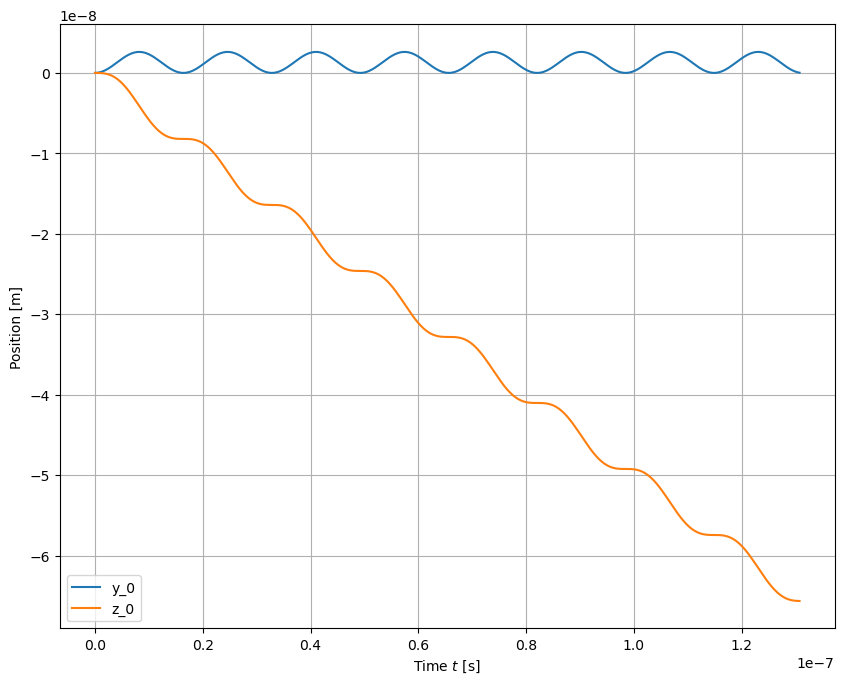

In [18]:
solution = trajectory.run(50 * gyroperiod, timestep)
solution.particletracker.plot_time_trajectories("yz")

Plot the shape of the trajectory in 3D.



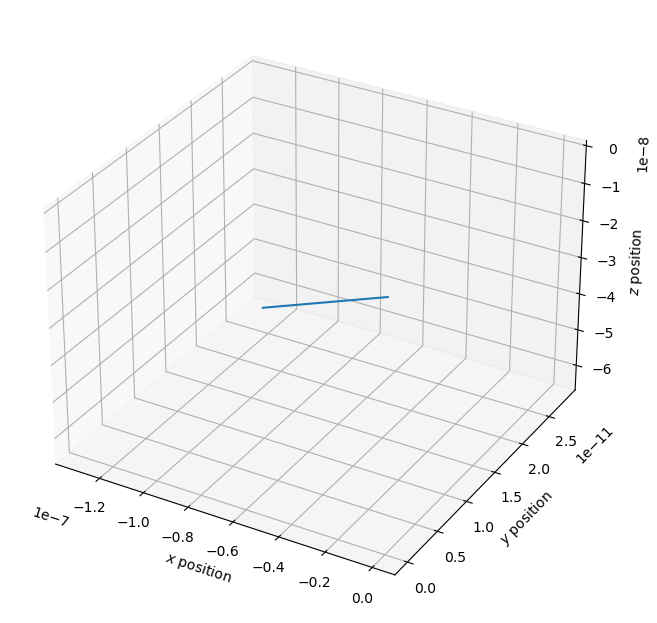

In [15]:
solution.particletracker.plot_trajectories()

This is consistent with the ExB drift being in the $-\hat{z}$ direction:

In [8]:
from plasmapy.formulary.drifts import ExB_drift

ExB_drift(electric_field(trajectory.x), magnetic_field(trajectory.x))

<Quantity [ 0. ,  0. , -0.5] m / s>

If you have Pyvista, you can run the following code - it'll open up a neat 3D visualization.

In [9]:
import pyvista

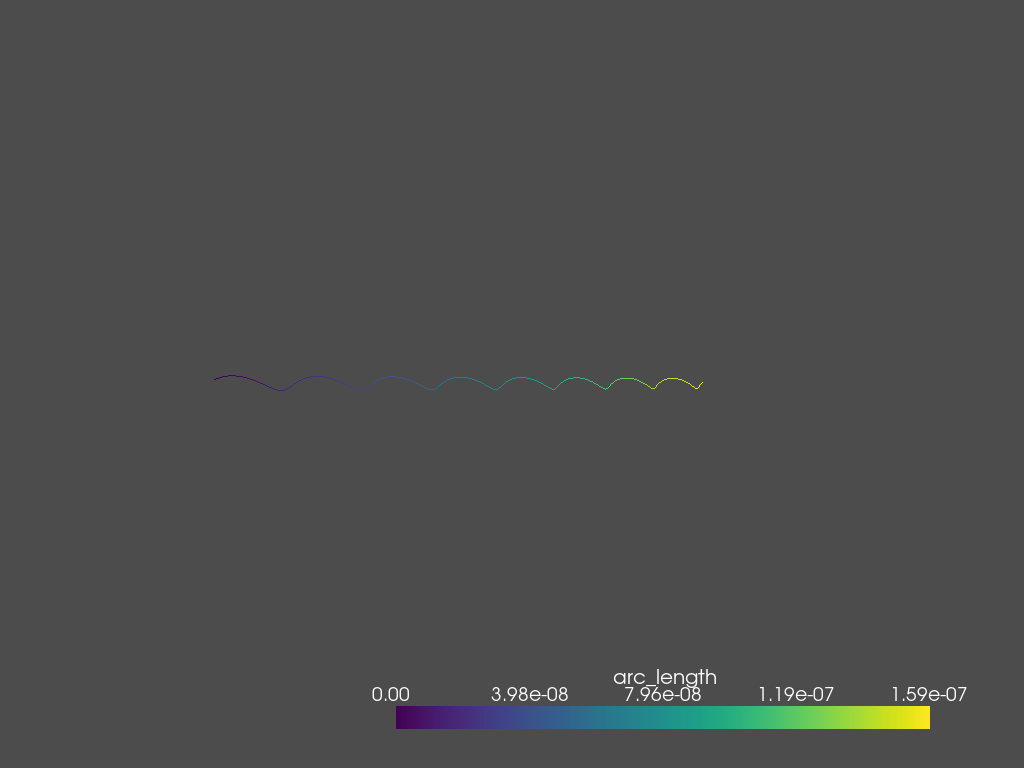

[(9.783645940557801e-08, 1.6452157794382356e-07, 1.303913497446207e-07),
 (-6.537852925703191e-08, 1.3065892812136326e-09, -3.282363891798923e-08),
 (0.0, 0.0, 1.0)]

In [11]:
fig = pyvista.Plotter()
solution.particletracker.visualize(fig)
fig.show()

As a test, we calculate the mean velocity in the z direction from the
velocity and position



In [12]:
vmean = solution.velocity.sel(dimension="z").mean().item()
print(
    f"The calculated drift velocity is {vmean:.4f} to compare with the "
    f"theoretical E0/B0 = {0.5 * u.m / u.s}"
)

The calculated drift velocity is -0.5011 to compare with the theoretical E0/B0 = 0.5 m / s


Supposing we wanted to examine the effect of the initial velocity in the x-y plane on the trajectory:



  0%|          | [00:00<?, ?it/s]

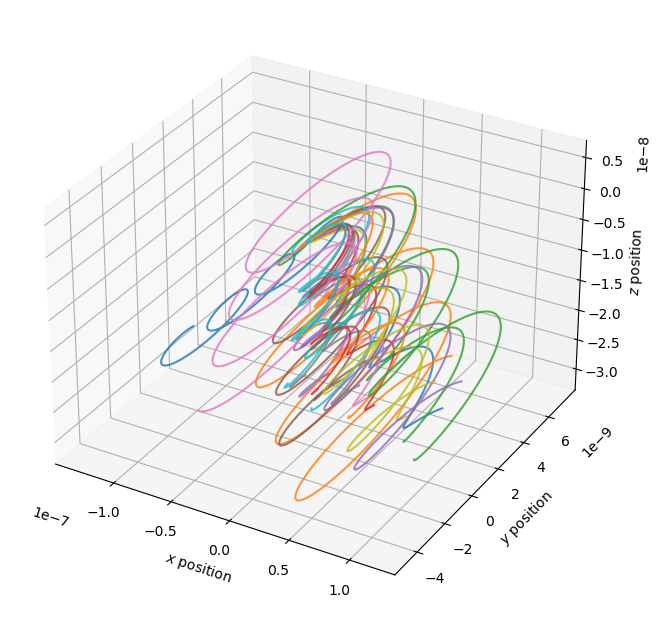

In [13]:
N = 20
np.random.seed(0)
v = np.zeros((N, 3))
v[:, :2] = np.random.normal(size=(N, 2))
trajectory = ParticleTracker(plasma, v=v * u.m / u.s, particle_type="p")
# we choose this as our example's thumbnail:
# sphinx_gallery_thumbnail_number = 3
solution = trajectory.run(gyroperiod * 20, timestep / 10)
solution.particletracker.plot_trajectories(alpha=0.8)

Note how while each trajectory fans out in a different way,
each one traverses the z direction in about the same time:



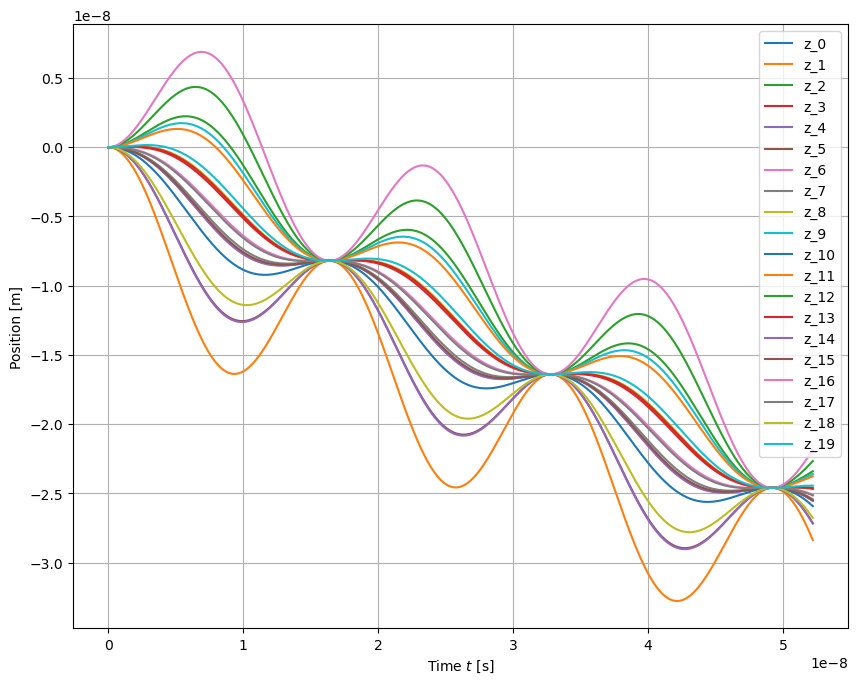

In [14]:
solution.particletracker.plot_time_trajectories("z")

And, optionally, with Pyvista:



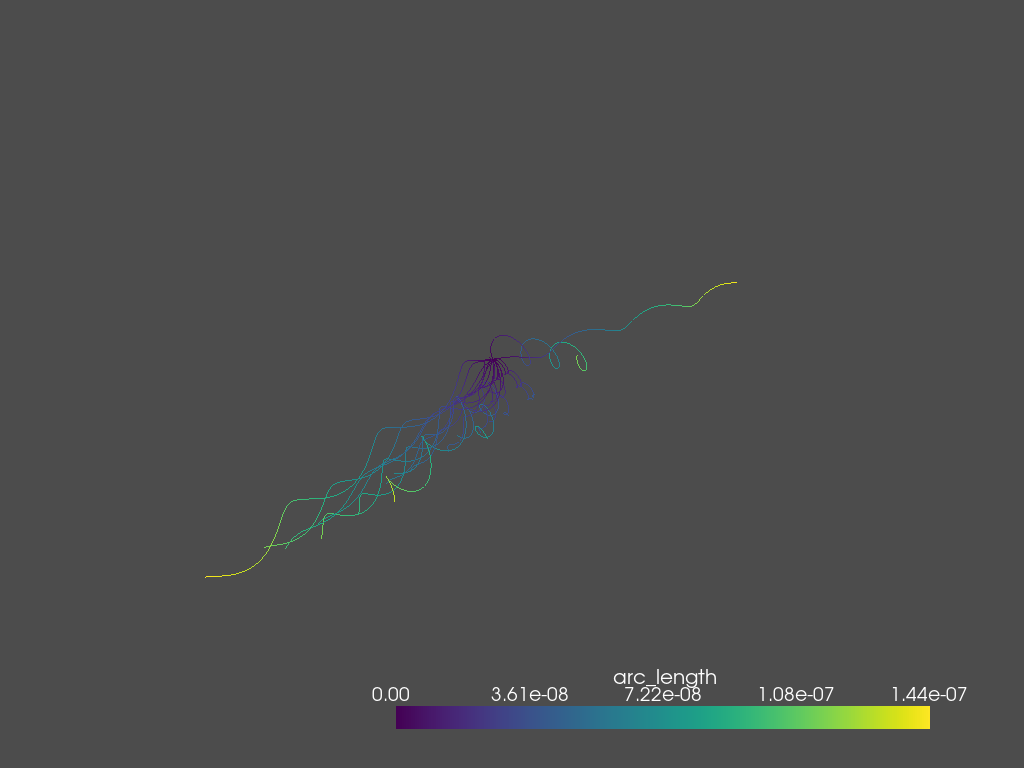

[(2.771630367106087e-07, 2.8586022967642064e-07, 2.7161347989652027e-07),
 (-7.3922166166084935e-09, 1.3049763492034572e-09, -1.2941773430696912e-08),
 (0.0, 0.0, 1.0)]

In [15]:
import pyvista

fig = pyvista.Plotter()
solution.particletracker.visualize(fig, solution.particle)
fig.show()